Dataset shape: (50000, 2)


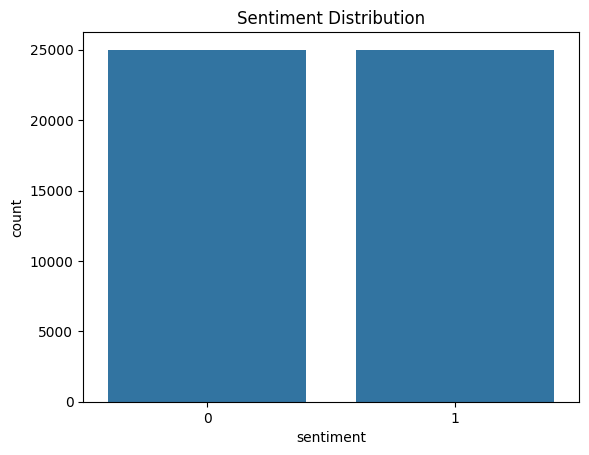

Training samples: 40000
Testing samples: 10000
🔹 Baseline Model Performance
Accuracy: 0.8944
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



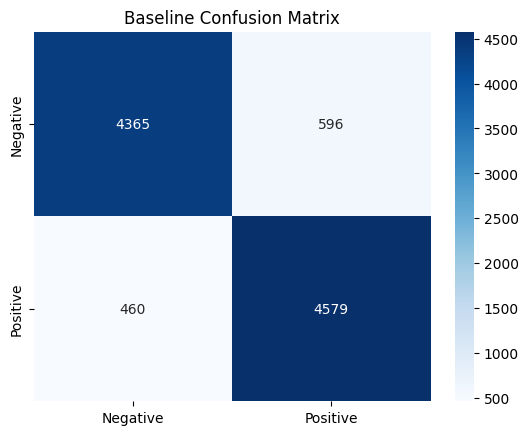

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
🔹 Tuned Model Performance
Accuracy: 0.8949
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



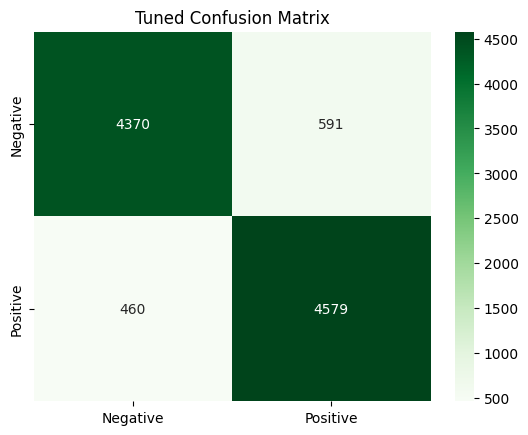

Tuned model saved in 'models/' folder
Review: The movie was absolutely fantastic!
Predicted Sentiment: Positive


In [3]:
# Sentiment Analysis Pipeline with Hyperparameter Tuning

# ======================
#  1. Import Libraries
# ======================
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings("ignore")

# ======================
#  2. Load Dataset
# ======================
df = pd.read_csv("IMDB Dataset.csv")

print("Dataset shape:", df.shape)
df.head()

# ======================
#  3. Data Preprocessing
# ======================
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text

df['review'] = df['review'].apply(clean_text)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

sns.countplot(x="sentiment", data=df)
plt.title("Sentiment Distribution")
plt.show()

# ======================
#  4. Train-Test Split
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

# ======================
#  5. TF-IDF Vectorization
# ======================
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ======================
#  6. Baseline Model (Logistic Regression)
# ======================
baseline_model = LogisticRegression(max_iter=200)
baseline_model.fit(X_train_vec, y_train)

y_pred_baseline = baseline_model.predict(X_test_vec)

print("🔹 Baseline Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Baseline Confusion Matrix")
plt.show()

# ======================
#  7. Hyperparameter Tuning with GridSearchCV
# ======================
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

grid = GridSearchCV(
    LogisticRegression(max_iter=200),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_vec, y_train)

print("Best Parameters:", grid.best_params_)

# ======================
#  8. Evaluate Tuned Model
# ======================
best_model = grid.best_estimator_
y_pred_tuned = best_model.predict(X_test_vec)

print("🔹 Tuned Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Tuned Confusion Matrix")
plt.show()

# ======================
#  9. Save the Best Model
# ======================
import os
os.makedirs("models", exist_ok=True)

joblib.dump(best_model, "models/sentiment_model.pkl")
joblib.dump(vectorizer, "models/vectorizer.pkl")
print("Tuned model saved in 'models/' folder")


# ======================
#  10. Test Sample Prediction
# ======================
sample_review = "The movie was absolutely fantastic!"
X_sample = vectorizer.transform([sample_review])
prediction = best_model.predict(X_sample)[0]
print(f"Review: {sample_review}")
print("Predicted Sentiment:", "Positive" if prediction == 1 else "Negative")


## 🚀 Deployment Note
- The trained model (`sentiment_model.pkl`) and vectorizer (`vectorizer.pkl`)  
  can be loaded in a FastAPI app (see `app/main.py`).  
- Wrap with Docker for easy deployment:
  ```bash
  docker build -t sentiment-api .
  docker run -p 8000:8000 sentiment-api
